In [1]:
import os
import sys
import pdb
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import torch
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam, lr_scheduler
import torchvision
import torchvision.transforms as T

from sys import platform

DEVICE = 'mps' if platform == 'darwin' else 'cuda'
if DEVICE == 'mps':
    DOWNLOAD_PATH = '/Users/georgestoica/Downloads' 
else:
    DOWNLOAD_PATH = '/srv/share/gstoica3/checkpoints/REPAIR/'

/srv/share/gstoica3/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE

'cuda'

In [3]:
def save_model(model, i):
    sd = model.state_dict()
    path = os.path.join(
        DOWNLOAD_PATH,
        '%s.pth.tar' % i
    )
    torch.save(model.state_dict(), path)

def load_model(model, i):
    path = os.path.join(
        DOWNLOAD_PATH,
        '%s.pth.tar' % i
    )
    sd = torch.load(path, map_location=torch.device(DEVICE))
    model.load_state_dict(sd)

In [4]:
CIFAR_MEAN = [125.307, 122.961, 113.8575]
CIFAR_STD = [51.5865, 50.847, 51.255]
normalize = T.Normalize(np.array(CIFAR_MEAN)/255, np.array(CIFAR_STD)/255)
denormalize = T.Normalize(-np.array(CIFAR_MEAN)/np.array(CIFAR_STD), 255/np.array(CIFAR_STD))

train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.ToTensor(),
    normalize,
])
test_transform = T.Compose([
    T.ToTensor(),
    normalize,
])
train_dset = torchvision.datasets.CIFAR10(root='/tmp', train=True,
                                        download=True, transform=train_transform)
test_dset = torchvision.datasets.CIFAR10(root='/tmp', train=False,
                                        download=True, transform=test_transform)

train_aug_loader = torch.utils.data.DataLoader(train_dset, batch_size=500, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=500, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
#             self.shortcut = LambdaLayer(lambda x:
#                                         F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(planes)
            )


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, w=1, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = w*16

        self.conv1 = nn.Conv2d(3, w*16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(w*16)
        self.layer1 = self._make_layer(block, w*16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, w*32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, w*64, num_blocks[2], stride=2)
        self.linear = nn.Linear(w*64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20(w=1):
    return ResNet(BasicBlock, [3, 3, 3], w=w)

In [6]:
# evaluates accuracy
def evaluate(model, loader=test_loader):
    model.eval()
    correct = 0
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.to(DEVICE))
            pred = outputs.argmax(dim=1)
            correct += (labels.to(DEVICE) == pred).sum().item()
    return correct

# evaluates loss
def evaluate1(model, loader=test_loader):
    model.eval()
    losses = []
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.to(DEVICE))
            loss = F.cross_entropy(outputs, labels.to(DEVICE))
            losses.append(loss.item())
    return np.array(losses).mean()

In [7]:
# modifies the weight matrices of a convolution and batchnorm
# layer given a permutation of the output channels
def permute_output(perm_map, conv, bn):
    pre_weights = [
        conv.weight,
        bn.weight,
        bn.bias,
        bn.running_mean,
        bn.running_var,
    ]
    for w in pre_weights:
        if len(w.shape) == 4:
            transform = torch.einsum('ab,bcde->acde', perm_map, w)
        elif len(w.shape) == 2:
            transform = perm_map @ w
        else:
            transform = w @ perm_map.t()
#         assert torch.allclose(w[perm_map.argmax(-1)], transform)
        w.data = transform
#         w.data = w[perm_map]

# modifies the weight matrix of a convolution layer for a given
# permutation of the input channels
def permute_input(perm_map, after_convs):
    if not isinstance(after_convs, list):
        after_convs = [after_convs]
    post_weights = [c.weight for c in after_convs]
    for w in post_weights:
        if len(w.shape) == 4:
            transform = torch.einsum('abcd,be->aecd', w, perm_map.t())
        elif len(w.shape) == 2:
            transform = w @ perm_map.t()
    #     assert torch.allclose(w[:, perm_map.argmax(-1)], transform)
        w.data = transform
#         w.data = w[:, perm_map, :, :]

def permute_cls_output(perm_map, linear):
    for w in [linear.weight, linear.bias]:
        w.data = perm_map @ w

In [70]:
modela = resnet20(w=4).to(DEVICE)
modelb = resnet20(w=4).to(DEVICE)
load_model(modela, 'resnet20x4_v1')
load_model(modelb, 'resnet20x4_v2')

evaluate(modela), evaluate(modelb)

(9536, 9510)

In [71]:
conv1_a = modela.conv1
conv1_b = modelb.conv1

bn1_a = modela.bn1
bn1_b = modelb.bn1
_ = modela.eval()
_ = modelb.eval()

In [72]:
output_prep = lambda x: x.flatten(1)
input_prep = lambda x: x.transpose(1, 0).flatten(1)

In [73]:
w_a = output_prep(conv1_a.weight).detach()
w_b = output_prep(conv1_b.weight).detach()
gamma_a = bn1_a.weight.detach()
gamma_b = bn1_b.weight.detach()
beta_a = bn1_a.bias.detach()
beta_b = bn1_b.bias.detach()
mu_a = bn1_a.running_mean.detach()
mu_b = bn1_b.running_mean.detach()
var_a = bn1_a.running_var.detach()
var_b = bn1_b.running_var.detach()

In [12]:
A = (gamma_a.reshape(-1, 1) * w_a) / var_a.reshape(-1, 1)
B = (gamma_b.reshape(-1, 1) * w_b) / var_b.reshape(-1, 1)

In [13]:
import geotorch
import torch
import torch.nn as nn

In [14]:
class P_Model(nn.Module):
    def __init__(
        self,
        bn1_a,
        bn1_b,
        w_a,
        w_b,
        dual_weight=100.
        
    ):
        super().__init__()
        
        self.bn1a = bn1_a
        self.bn1b = bn1_b
        
        self.bn1a.eval()
        self.bn1b.eval()
        
        self.gamma_a = bn1_a.weight.detach()
        self.gamma_b = bn1_b.weight.detach()
        self.beta_a = bn1_a.bias.detach()
        self.beta_b = bn1_b.bias.detach()
        self.mu_a = bn1_a.running_mean.detach()
        self.mu_b = bn1_b.running_mean.detach()
        self.var_a = bn1_a.running_var.detach()
        self.var_b = bn1_b.running_var.detach()
        self.A = (self.gamma_a.reshape(-1, 1) * w_a) / self.var_a.reshape(-1, 1)
        self.B = (self.gamma_b.reshape(-1, 1) * w_b) / self.var_b.reshape(-1, 1)
        self.dual_weight = dual_weight
        
        self.P = nn.Linear(64,64, bias=False)
        geotorch.orthogonal(self.P, 'weight')
    
    def compute_objective(self):
        obj_beta = torch.norm(self.P(self.beta_a) - self.beta_b)
        obj_C = torch.norm(self.P(self.A.T).T - self.B)
        obj_mu = torch.norm(self.P(self.mu_a) - self.mu_b)
        return obj_beta + obj_C + obj_mu
    
    def forward(self, x):
        main_obj = self.compute_objective()
        constraint = self.compute_equality_constraint(x)
        return main_obj + constraint * self.dual_weight
    
    def compute_P_batch_norm(self, x):
        unit_norm = (x - self.mu_a.view(1, -1, 1, 1)) / (torch.sqrt(self.var_a.view(1, -1, 1, 1) + 1e-5))
        scaled = unit_norm * self.gamma_a.view(1, -1, 1, 1) + self.beta_a.view(1, -1, 1, 1)
        # pdb.set_trace()
        return torch.einsum('ab,cbde->cade', self.P.weight, scaled)
    
    def compute_equality_constraint(self, x):
        P_bn = self.compute_P_batch_norm(x)
        P_w = self.P.weight
        reverted = torch.einsum('ab,cbde->cade', P_w.T, F.relu(P_bn))
        return torch.norm(reverted - self.bn1a(x))
        

In [24]:
model = P_Model(
    bn1_a=bn1_a,
    bn1_b=bn1_b,
    w_a=output_prep(conv1_a.weight.detach()),
    w_b=output_prep(conv1_b.weight.detach()),
    dual_weight=1.
)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=.003)

In [21]:
def solve_P(P_model):
#     optimizer = SGD(model.parameters(), lr=0.4, momentum=0.9, weight_decay=5e-4)
    optimizer = torch.optim.Adam(model.parameters(), lr=.003)

    EPOCHS = 100
    ne_iters = len(train_aug_loader)
    # lr_schedule = np.interp(np.arange(1+EPOCHS*ne_iters), [0, 5*ne_iters, EPOCHS*ne_iters], [0, 1, 0])
    # scheduler = lr_scheduler.LambdaLR(optimizer, lr_schedule.__getitem__)

    # scaler = GradScaler()
    # loss_fn = CrossEntropyLoss()
    
    losses = []
    for _ in tqdm(range(EPOCHS)):
        for i, (inputs, labels) in enumerate(train_aug_loader):
            optimizer.zero_grad(set_to_none=True)
            #with autocast():
            loss = model(conv1_a(inputs.to(DEVICE)))
            #scaler.scale(loss).backward()
            #scaler.step(optimizer)
            #scaler.update()
            #scheduler.step()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
    return P_model, losses

In [22]:
solved_model, losses = solve_P(model)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:17<00:00,  4.38s/it]


In [ ]:
for _ in tqdm(range(100)):
    for i, (inputs, labels) in enumerate(train_aug_loader):
        optimizer.zero_grad(set_to_none=True)
        #with autocast():
        loss = model(conv1_a(inputs.to(DEVICE)))
        #scaler.scale(loss).backward()
        #scaler.step(optimizer)
        #scaler.update()
        #scheduler.step()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

# ------------------------------------ OLD CODE ------------------------------------

In [ ]:
lr_schedule = np.interp(np.arange(1+EPOCHS*ne_iters), [0, 5*ne_iters, EPOCHS*ne_iters], [0, 1, 0])
ne_iters = len(train_aug_loader)
for i in range(1, 101):
    
    
    optimizer.zero_grad()
    loss = model((gamma_a, gamma_b, A, B, mu_a, mu_b))
    loss.backward(retain_graph=True)
    optimizer.step()
    if i == 0 or i % 100 == 1:
        print('step {}: {:.3f}'.format(i, loss))

In [26]:
P = model.P.weight

In [27]:
P

tensor([[-0.0677,  0.0458, -0.0819,  ..., -0.0334, -0.2623, -0.0855],
        [ 0.0061,  0.2445,  0.0249,  ...,  0.0814,  0.0349,  0.0623],
        [-0.1885, -0.0012,  0.0653,  ...,  0.2413, -0.0850,  0.0567],
        ...,
        [-0.0719, -0.1864,  0.0801,  ...,  0.1399, -0.0520,  0.1856],
        [ 0.6094,  0.0635,  0.0722,  ...,  0.0659,  0.1676, -0.0446],
        [-0.0732,  0.0541,  0.0268,  ..., -0.1335,  0.2461, -0.1685]],
       grad_fn=<AliasBackward0>)

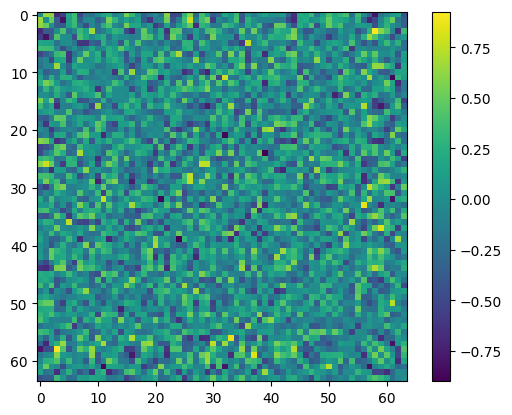

tensor(15, device='cuda:0')

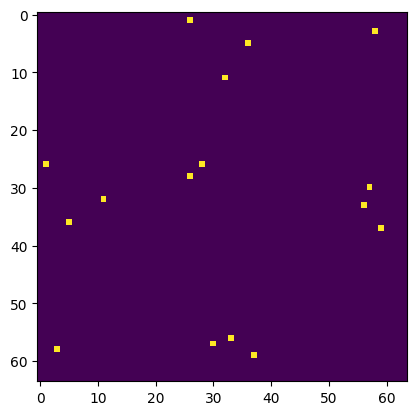

In [44]:
u_a = w_a / torch.norm(w_a, dim=1, keepdim=True)
u_b = w_b / torch.norm(w_b, dim=1, keepdim=True)
cossim = u_a @ u_a.T
cossim = cossim - torch.eye(cossim.shape[0], device=cossim.device)
import matplotlib.pyplot as plt
plt.imshow(cossim.cpu().numpy())
plt.colorbar()
plt.show()


plt.imshow((cossim > 0.75).cpu().numpy())

(cossim > 0.75).any(dim=0).sum()

In [45]:
64-15

49

In [46]:
49*2-64

34

In [48]:
def bipartite_soft_matching(
    metric: torch.Tensor,
    r: int,
    class_token: bool = False,
    distill_token: bool = False,
):
    """
    Applies ToMe with a balanced matching set (50%, 50%).
    Input size is [batch, tokens, channels].
    r indicates the number of tokens to remove (max 50% of tokens).
    Extra args:
     - class_token: Whether or not there's a class token.
     - distill_token: Whether or not there's also a distillation token.
    When enabled, the class token and distillation tokens won't get merged.
    """
    protected = 0
    if class_token:
        protected += 1
    if distill_token:
        protected += 1

    # We can only reduce by a maximum of 50% tokens
    t = metric.shape[1]
    r = min(r, (t - protected) // 2)

    if r <= 0:
        return do_nothing, do_nothing

    with torch.no_grad():
        metric = metric / metric.norm(dim=-1, keepdim=True)
        a, b = metric[..., ::2, :], metric[..., 1::2, :]
        scores = a @ b.transpose(-1, -2)

        if class_token:
            scores[..., 0, :] = -math.inf
        if distill_token:
            scores[..., :, 0] = -math.inf

        node_max, node_idx = scores.max(dim=-1)
        edge_idx = node_max.argsort(dim=-1, descending=True)[..., None]

        unm_idx = edge_idx[..., r:, :]  # Unmerged Tokens
        src_idx = edge_idx[..., :r, :]  # Merged Tokens
        dst_idx = node_idx[..., None].gather(dim=-2, index=src_idx)

        if class_token:
            # Sort to ensure the class token is at the start
            unm_idx = unm_idx.sort(dim=1)[0]

    def merge(x: torch.Tensor, mode="mean") -> torch.Tensor:
        src, dst = x[..., ::2, :], x[..., 1::2, :]
        n, t1, c = src.shape
        unm = src.gather(dim=-2, index=unm_idx.expand(n, t1 - r, c))
        src = src.gather(dim=-2, index=src_idx.expand(n, r, c))
        dst = dst.scatter_reduce(-2, dst_idx.expand(n, r, c), src, reduce=mode)

        if distill_token:
            return torch.cat([unm[:, :1], dst[:, :1], unm[:, 1:], dst[:, 1:]], dim=1)
        else:
            return torch.cat([unm, dst], dim=1)

    def unmerge(x: torch.Tensor) -> torch.Tensor:
        unm_len = unm_idx.shape[1]
        unm, dst = x[..., :unm_len, :], x[..., unm_len:, :]
        n, _, c = unm.shape

        src = dst.gather(dim=-2, index=dst_idx.expand(n, r, c))

        out = torch.zeros(n, metric.shape[1], c, device=x.device, dtype=x.dtype)

        out[..., 1::2, :] = dst
        out.scatter_(dim=-2, index=(2 * unm_idx).expand(n, unm_len, c), src=unm)
        out.scatter_(dim=-2, index=(2 * src_idx).expand(n, r, c), src=src)

        return out

    return merge, unmerge



In [117]:
modela = resnet20(w=4).to(DEVICE)
modelb = resnet20(w=4).to(DEVICE)
load_model(modela, 'resnet20x4_v1')
load_model(modelb, 'resnet20x4_v2')

evaluate(modela), evaluate(modelb)

(9536, 9510)

In [ ]:
for key in modela.state_dict():
    value_a = output_prep(modela[key])
    value_b = output_prep(modelb[key])
    interleaved = torch.cat((value_a, value_b), dim=0)
    

In [118]:
# [64, 32, 3, 3] |interleave| [64, 32, 3, 3] -> [9, 128, 32]
# apply tome, get merge function -> [9, 64, 32] - > [64, 32, 3, 3]
# next layer: [128, 64, 3, 3] -> [9, 128, 64] -> [9, 64, 128] (a) |interlave| [9, 64, 128] (b)
# -> [9, 128, 128] -> merge -> [9, 64, 128] -> [9, 128, 64]

In [110]:
conv1_a = modela.conv1
conv1_b = modelb.conv1

bn1_a = modela.bn1
bn1_b = modelb.bn1
_ = modela.eval()
_ = modelb.eval()


orig_shape = modela.layer3[2].conv2.weight.shape
w_a = output_prep(modela.layer3[2].conv2.weight).detach()

In [111]:
w_a.shape, orig_shape

(torch.Size([256, 2304]), torch.Size([256, 256, 3, 3]))

In [112]:
inp = w_a[None, ...]

merge, unmerge = bipartite_soft_matching(inp, r=128)

out = unmerge(merge(inp))[0]

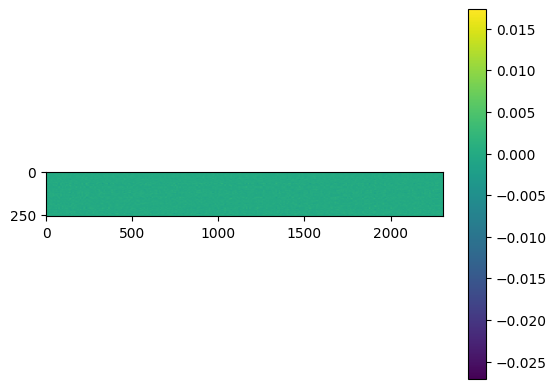

In [113]:
plt.imshow((out - w_a).cpu().numpy())
plt.colorbar()

In [114]:
modela.layer3[2].conv2.weight.data = out.reshape(*orig_shape)

In [115]:
evaluate(modela)

9537

In [116]:
# modela

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=